# Model Run Mandarin
Version 1.0  

Version 2.0
Added dropout layer. 

Version 3.0  
Lowered dimensionality. 

Version 4.0  
Changed ReLU to Tanh

Version 5.0  
Deleted resblock

Version 6.0  
Added back. Hiddim back to 3. 

Version 7.0  
This time using MF data. 

Version 8.0  
Very new! Now we are using flying dataset. As to normalizer we are not using strip mvn. 

Version 10.0  
Cancelling flying dataset. But normalizer is done there. 

## Import Libs

In [1]:
import matplotlib.pyplot as plt
import os
import torch
from torch import optim
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure
import pickle
import random

from paths import *
from ssd_paths import *
# from model_config import *
from model_dataset import *
# from model_model import *
from my_utils import get_timestamp
from misc_recorder import *
from misc_progress_bar import draw_progress_bar

## Localize Dirs

In [2]:
model_save_ = model_man_save_dir

random_train_data_ = os.path.join(as_use_path, "phone_random_train.mfcc")
radnom_valid_data_ = os.path.join(as_use_path, "phone_random_test.mfcc")
# the anno_test_data_ is much smaller than the valid_data_, so we switch them
anno_valid_data_ = os.path.join(as_use_path, "phone_anno_test.mfcc")

random_train_guide_ = os.path.join(as_use_path, "phone_random_train.csv")
random_valid_guide_ = os.path.join(as_use_path, "phone_random_test.csv")
anno_valid_guide_ = os.path.join(as_use_path, "phone_anno_test.csv")

In [3]:
# for file in os.listdir(as_use_path): 
#     if file.endswith(".csv"): 
#         guide_log = pd.read_csv(os.path.join(as_use_path, file))
#         guide_log = guide_log[guide_log['n_frames'] > 400]
#         guide_log = guide_log[guide_log['duration'] <= 2.0]
#         assert len(guide_log) == len(torch.load(os.path.join(as_use_path, file[:-4] + ".mfcc")))

#         guide_log.to_csv(os.path.join(as_use_path, file), index=False)

## Configure READ

In [4]:
READ = False

In [5]:
BATCH_SIZE = 128
LOADER_WORKER = 16

FRAMES_IN_SEGMENT = 25

MFCC_DIM = 13
INPUT_DIM = FRAMES_IN_SEGMENT * MFCC_DIM * 3
OUTPUT_DIM = FRAMES_IN_SEGMENT * MFCC_DIM
# let's still maintain these interdims but just ignore them when building the model 
INTER_DIM_1 = 256
INTER_DIM_2 = 64
INTER_DIM_3 = 16
LATENT_DIM = 8

DROPOUT = 0.5

## Get Training Stamp

In [6]:
if READ: 
    ts = "1116223120"
else: 
    ts = str(get_timestamp())

train_name = "dim-8"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
mk(model_save_dir)

stop_epoch = "32"
trainhist_name = "train.hst"
valhist_name = "val.hst"
valacc_name = "valacc.hst"
print(f"{train_name}-{ts}")

MFNewNorm-1124142422


## Prepare Loss Recording

In [7]:
train_losses = ListRecorder(os.path.join(model_save_dir, trainhist_name))
valid_losses = ListRecorder(os.path.join(model_save_dir, valhist_name))

# valid_accs = ListRecorder(os.path.join(model_save_dir, valacc_name))

In [8]:
TYPE = "part"

In [9]:
# transform = nn.Sequential(
#     Resampler(4240, 1), 
#     MFCCTransform()
# )
# normalizer=Normalizer.norm_strip_mvn

train_ds = UngroundedSoundDataset(random_train_data_, random_train_guide_)
valid_ds = UngroundedSoundDataset(radnom_valid_data_, random_valid_guide_)

if TYPE == "part": 
    use_len = int(0.1 * len(train_ds))
    remain_len = len(train_ds) - use_len
    use_train_ds, remain_ds = random_split(train_ds, [use_len, remain_len])

    use_len = int(0.1 * len(valid_ds))
    remain_len = len(valid_ds) - use_len
    use_valid_ds, remain_ds = random_split(valid_ds, [use_len, remain_len])

    train_loader = DataLoader(use_train_ds, batch_size=BATCH_SIZE, 
                            shuffle=True, 
                            num_workers=LOADER_WORKER)
    train_num = len(train_loader.dataset)

    valid_loader = DataLoader(use_valid_ds, batch_size=BATCH_SIZE, 
                            shuffle=False, 
                            num_workers=LOADER_WORKER)
elif TYPE == "full": 
    use_train_ds = train_ds
    use_valid_ds = valid_ds
    
elif TYPE == "same":
    train_len = int(0.8 * len(train_ds))
    valid_len = len(train_ds) - train_len
    use_train_ds, use_valid_ds = random_split(train_ds, [train_len, valid_len])

train_loader = DataLoader(use_train_ds, batch_size=BATCH_SIZE, 
                        shuffle=True, 
                        num_workers=LOADER_WORKER)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(use_valid_ds, batch_size=BATCH_SIZE, 
                        shuffle=False, 
                        num_workers=LOADER_WORKER)
valid_num = len(valid_loader.dataset)

817955 817955
65726 65726


In [10]:
train_num, valid_num

(81795, 6572)

## Init Model

In [11]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.lin1 = nn.Linear(n_chans, n_chans)
        self.lin2 = nn.Linear(n_chans, n_chans)
        # self.batch_norm = nn.BatchNorm1d(num_features=n_chans)  # <5>
        self.batch_norm = nn.LayerNorm(n_chans)
        # self.dropout = nn.Dropout(p=DROPOUT)
        self.relu = nn.ReLU()
        # self.relu = nn.ReLU()
        # self.relu = nn.Tanh()

    def forward(self, x):
        out = self.lin1(x)
        out = self.batch_norm(out)
        out = self.relu(out)
        out = self.lin2(out)
        out = self.batch_norm(out)
        out = self.relu(out)
        out = out + x
        # out = self.dropout(out)
        return out

class LinPack(nn.Module):
    def __init__(self, n_in, n_out):
        super(LinPack, self).__init__()
        self.lin = nn.Linear(n_in, n_out)
        self.relu = nn.ReLU()
        # self.relu = nn.ReLU()
        # self.relu = nn.Tanh()
        # self.batch_norm = nn.BatchNorm1d(num_features=n_out)
        self.batch_norm = nn.LayerNorm(n_out)
        self.dropout = nn.Dropout(p=DROPOUT)

    def forward(self, x):
        x = self.lin(x)
        x = self.relu(x)
        x = self.batch_norm(x)
        x = self.dropout(x)
        return x


class ResAE(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, inter_dim1=INTER_DIM_1, inter_dim2=INTER_DIM_2, inter_dim3=INTER_DIM_3, latent_dim=LATENT_DIM, output_dim=OUTPUT_DIM):
        super(ResAE, self).__init__()

        self.encoder = nn.Sequential(
            LinPack(input_dim, inter_dim1), 
            # LinPack(inter_dim1, inter_dim3), 
            ResBlock(inter_dim1), 

            nn.Linear(inter_dim1, latent_dim), 
            nn.Sigmoid()
        )

        self.decoder =  nn.Sequential(
            LinPack(latent_dim, inter_dim1), 
            # LinPack(inter_dim3, inter_dim1),
            ResBlock(inter_dim1), 

            nn.Linear(inter_dim1, output_dim),
            # nn.Sigmoid(),
        )

        # initialize the weights
        self.encoder.apply(self.init_weights)
        self.decoder.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            m.bias.data.fill_(0.01)

    def forward(self, x):
        org_size = x.size()
        y_size = (org_size[0], org_size[1], org_size[2] // 3)
        batch = org_size[0]
        x = x.view(batch, -1)

        h = self.encoder(x)
        recon_x = self.decoder(h).view(size=y_size)

        return recon_x
    
    def encode(self, x):
        org_size = x.size()
        y_size = (org_size[0], org_size[1], org_size[2] // 3)
        batch = org_size[0]
        x = x.view(batch, -1)

        h = self.encoder(x)
        return h

In [12]:
recon_loss = nn.MSELoss()
# recon_loss = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResAE(INPUT_DIM, INTER_DIM_1, INTER_DIM_2, INTER_DIM_3, LATENT_DIM, OUTPUT_DIM)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Define the file path and name
model_info_file = os.path.join(model_save_dir, 'model.txt')

# Open the file in write mode
with open(model_info_file, 'w') as f:
    f.write(str(model))
    f.write('\n\n')
    f.write(str(summary(model, input_size=(BATCH_SIZE, FRAMES_IN_SEGMENT, MFCC_DIM * 3))))
model

/home/ldlmdl/anaconda3/envs/featln/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ResAE(
  (encoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=975, out_features=256, bias=True)
      (relu): ReLU()
      (batch_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): ResBlock(
      (lin1): Linear(in_features=256, out_features=256, bias=True)
      (lin2): Linear(in_features=256, out_features=256, bias=True)
      (batch_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
    (2): Linear(in_features=256, out_features=8, bias=True)
    (3): Sigmoid()
  )
  (decoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=8, out_features=256, bias=True)
      (relu): ReLU()
      (batch_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): ResBlock(
      (lin1): Linear(in_features=256, out_features=256, bias=True)
      (lin2): Linear(in_features=256, out_features=256, bi

In [13]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

602957

## Load Model if READ

In [14]:
if READ: 
    valid_losses.read()
    train_losses.read()

    model_raw_name = f"{stop_epoch}"
    model_name = model_raw_name + ".pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

## Define Training

In [15]:
def draw_learning_curve(losses, others, epoch="", save_path=None): 
    train_losses, valid_losses = losses
    best_val_loss = others
    plt.clf()
    # fig, (ax1) = plt.subplots(1, 1, figsize=(18, 4))
    plt.plot(train_losses, label='Train')
    plt.plot(valid_losses, label='Valid')
    plt.axvline(x=best_val_loss, color='r', linestyle='--', label=f'Best: {best_val_loss}')
    plt.title("Learning Curve Loss" + f" {epoch}")
    plt.legend(loc="upper right")

    plt.tight_layout()
    plt.xlabel("Epoch")
    display.clear_output(wait=True)
    display.display(plt.gcf())
    if save_path: 
        plt.savefig(save_path)

In [16]:
best_valid_loss = 1e9
best_valid_loss_epoch = 0

In [17]:
EPOCHS = 50
BASE =0

In [18]:
def train(best_valid_loss, best_valid_loss_epoch): 
    for epoch in range(BASE, BASE + EPOCHS):
        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        for idx, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)

            x_hat= model(x)
            loss = recon_loss(x_hat, y)
            train_loss += loss.item()
            
            loss.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            # 这个函数计算的是全局梯度范数
            # torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=5, norm_type=2)
            # torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
            # parameters: an iterable of Variables that will have gradients normalized
            # max_norm: max norm of the gradients(阈值设定)
            # norm_type: type of the used p-norm. Can be'inf'for infinity norm(定义范数类型)

            optimizer.step()
            # scheduler.step()

            draw_progress_bar(idx, train_num)

        train_losses.append(train_loss / train_num)

        last_model_name = f"{epoch}.pt"
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))

        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        for idx, (x, y) in enumerate(valid_loader):
            x = x.to(device)
            y = y.to(device)

            x_hat = model(x)
            loss = recon_loss(x_hat, y)
            
            valid_loss += loss.item()

            # draw_progress_bar(idx, valid_num)

        avg_valid_loss = valid_loss / valid_num
        valid_losses.append(avg_valid_loss)
        if avg_valid_loss < best_valid_loss: 
            best_valid_loss = avg_valid_loss
            best_valid_loss_epoch = epoch

        draw_learning_curve(losses=(train_losses.get(), valid_losses.get()),
                            others=best_valid_loss_epoch, 
                            epoch=str(epoch))
        train_losses.save()
        valid_losses.save()

    return best_valid_loss, best_valid_loss_epoch

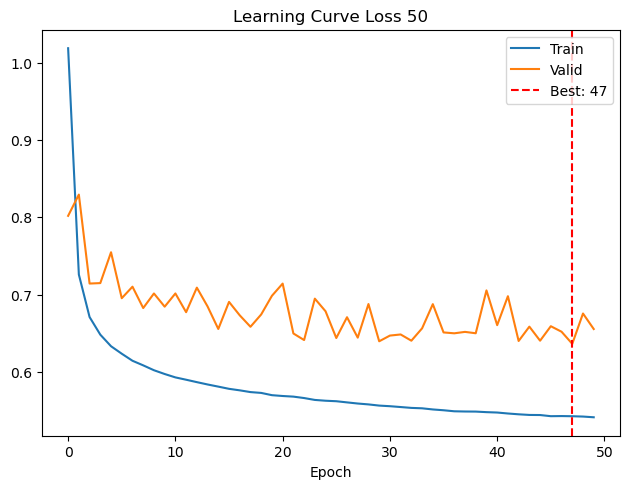

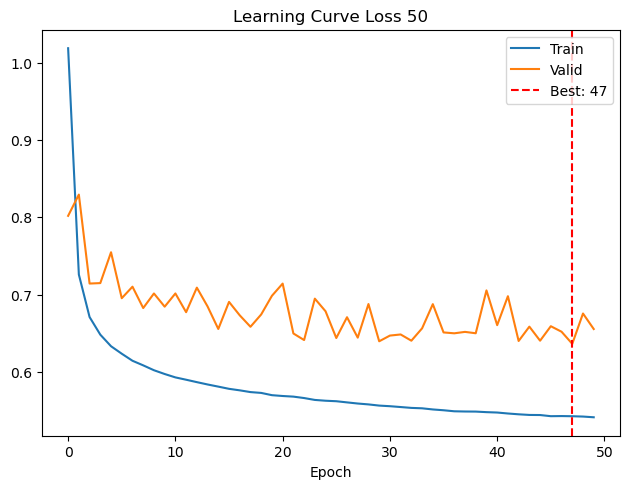

In [19]:
if __name__ == "__main__": 
    best_valid_loss, best_valid_loss_epoch = train(best_valid_loss, best_valid_loss_epoch)
    draw_learning_curve(losses=(train_losses.get(), valid_losses.get()), 
                        others=best_valid_loss_epoch, 
                        epoch=str(BASE + EPOCHS), 
                        save_path=os.path.join(model_save_dir, "vis.png"))

## Compare prediction

In [20]:
def checkone(): 
    model.eval()
    valid_loss = 0.
    valid_num = len(valid_loader.dataset)
    for idx, (x, y) in enumerate(valid_loader):
        x = x.to(device)
        y = y.to(device)

        x_hat = model(x)
        return y, x_hat

In [21]:
target, pred = checkone()

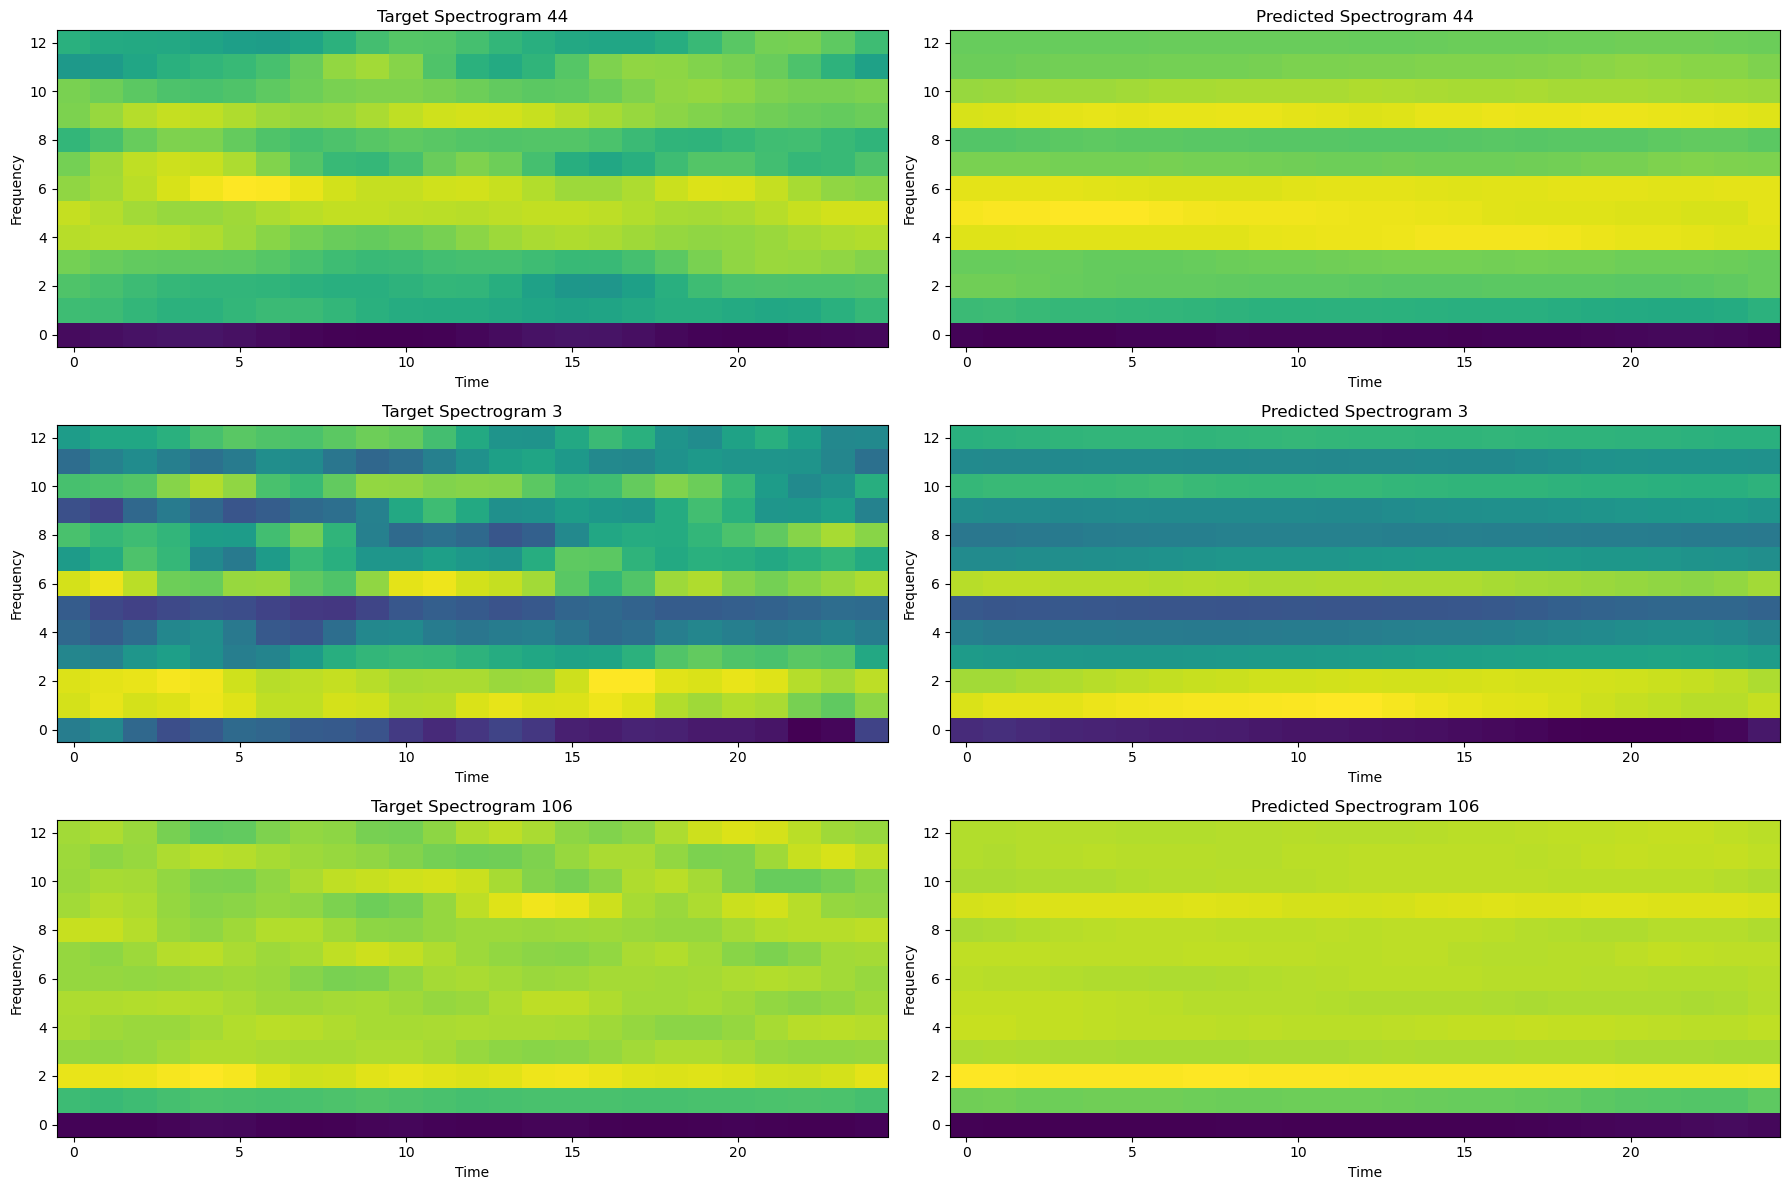

In [22]:
# Set the random seed for reproducibility
# random.seed(101)
# Generate six random indices
random_indices = random.sample(range(len(target)), 3)

# Create subplots with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(18, 12))

# Flatten the axes array
axes = axes.flatten()

# Iterate over the random indices
for i, idx in enumerate(random_indices):
    targetspec = target[idx]
    predspec = pred[idx]
    
    # Plot the target spectrogram
    ax = axes[i*2]
    ax.imshow(targetspec.detach().cpu().numpy().T, aspect='auto', origin="lower")
    ax.set_title(f'Target Spectrogram {idx}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    
    # Plot the predicted spectrogram
    ax = axes[i*2+1]
    ax.imshow(predspec.detach().cpu().numpy().T, aspect='auto', origin="lower")
    ax.set_title(f'Predicted Spectrogram {idx}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


## Clustering Evaluation

### Set a csv record

In [76]:
HCV_rec = pd.DataFrame(columns=["type", "homogeneity", "completeness", "v_measure"])

### Our result (Heimsprache)

In [70]:
gsds = GroundedSoundDataset(os.path.join(as_use_path, "phone_anno_validation.mfcc"), os.path.join(as_use_path, "phone_anno_validation.csv"))
eval_loader = DataLoader(gsds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER)

In [71]:
stop_epoch = best_valid_loss_epoch
model_raw_name = f"{stop_epoch}"
model_name = model_raw_name + ".pt"
model_path = os.path.join(model_save_dir, model_name)
state = torch.load(model_path)

model.load_state_dict(state)
model.to(device)

ResAE(
  (encoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=975, out_features=256, bias=True)
      (relu): ReLU()
      (batch_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): ResBlock(
      (lin1): Linear(in_features=256, out_features=256, bias=True)
      (lin2): Linear(in_features=256, out_features=256, bias=True)
      (batch_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
    (2): Linear(in_features=256, out_features=8, bias=True)
    (3): Sigmoid()
  )
  (decoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=8, out_features=256, bias=True)
      (relu): ReLU()
      (batch_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): ResBlock(
      (lin1): Linear(in_features=256, out_features=256, bias=True)
      (lin2): Linear(in_features=256, out_features=256, bi

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
hiddens = None
tags = None
model.eval()
with torch.no_grad():
    for idx, (s, e, t) in enumerate(eval_loader):
        s = s.to(device)
        hidden = model.encode(s)
        hidden = hidden.cpu().data.numpy()

        if hiddens is not None: 
            hiddens = np.concatenate((hiddens, hidden), axis=0)
            tags = np.concatenate((tags, t), axis=0)
        else: 
            hiddens = hidden
            tags = t
num_phones = np.unique(tags).shape[0]
kmeansmodel = KMeans(n_clusters=256) # , random_state=0
clusters = kmeansmodel.fit_predict(hiddens)
np.save(os.path.join(model_save_dir, "heim_cluster.npy"), clusters)
np.save(os.path.join(model_save_dir, "heim_hiddens.npy"), hiddens)
np.save(os.path.join(model_save_dir, "heim_tags.npy"), hiddens)

/home/ldlmdl/anaconda3/envs/featln/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [77]:
h, c, v = homogeneity_completeness_v_measure(tags, clusters)

In [78]:
h, c, v

(0.4444993005086059, 0.3205389013790592, 0.372476347186934)

In [79]:
HCV_rec = pd.concat((HCV_rec, pd.DataFrame({"type": ["heim"], "homogeneity": [h], "completeness": [c], "v_measure": [v]})), ignore_index=True)

/tmp/ipykernel_205623/3375830325.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  HCV_rec = pd.concat((HCV_rec, pd.DataFrame({"type": ["heim"], "homogeneity": [h], "completeness": [c], "v_measure": [v]})), ignore_index=True)


### Baseline

In [83]:
clusters_base = np.random.randint(0, 256, size=hiddens.shape[0])
hb, cb, vb = homogeneity_completeness_v_measure(tags, clusters_base)
print(hb, cb, vb)

0.047238508924391215 0.03266555478736746 0.038623119517666525


In [84]:
v/vb

9.643870092278805

In [85]:
HCV_rec = pd.concat((HCV_rec, pd.DataFrame({"type": ["base"], "homogeneity": [hb], "completeness": [cb], "v_measure": [vb]})), ignore_index=True)

In [ ]:
# (0.1767405331125321, 0.300229269600411, 0.22249912201296201)
# (0.317775819160334, 0.23803955507549407, 0.2721882773058442)
# (0.22059468942414573, 0.15012069012334261, 0.17865904055191792)
# (0.33517317818409614, 0.2217166931537156, 0.26688755721944174)

# (0.3641088741524852, 0.24123384101870463, 0.2902005097590394)

### Use English data (Fremdsprache)

In [89]:
fremd_anno_test_data_ = os.path.join(sbsc_use_path, "phone_anno_test.mfcc")
fremd_anno_test_guide_ = os.path.join(sbsc_use_path, "phone_anno_test.csv")

In [90]:
gsds = GroundedSoundDataset(fremd_anno_test_data_, fremd_anno_test_guide_)
eval_loader = DataLoader(gsds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER)

In [91]:
best_valid_loss_epoch

47

In [92]:
stop_epoch = best_valid_loss_epoch
model_raw_name = f"{stop_epoch}"
model_name = model_raw_name + ".pt"
model_path = os.path.join(model_save_dir, model_name)
state = torch.load(model_path)

model.load_state_dict(state)
model.to(device)

ResAE(
  (encoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=975, out_features=256, bias=True)
      (relu): ReLU()
      (batch_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): ResBlock(
      (lin1): Linear(in_features=256, out_features=256, bias=True)
      (lin2): Linear(in_features=256, out_features=256, bias=True)
      (batch_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
    (2): Linear(in_features=256, out_features=8, bias=True)
    (3): Sigmoid()
  )
  (decoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=8, out_features=256, bias=True)
      (relu): ReLU()
      (batch_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): ResBlock(
      (lin1): Linear(in_features=256, out_features=256, bias=True)
      (lin2): Linear(in_features=256, out_features=256, bi

In [93]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
hiddens = None
tags = None
model.eval()
with torch.no_grad():
    for idx, (s, e, t) in enumerate(eval_loader):
        s = s.to(device)
        hidden = model.encode(s)
        hidden = hidden.cpu().data.numpy()

        if hiddens is not None: 
            hiddens = np.concatenate((hiddens, hidden), axis=0)
            tags = np.concatenate((tags, t), axis=0)
        else: 
            hiddens = hidden
            tags = t
num_phones = np.unique(tags).shape[0]
kmeansmodel = KMeans(n_clusters=256) # , random_state=0
clusters = kmeansmodel.fit_predict(hiddens)
np.save(os.path.join(model_save_dir, "fremd_cluster.npy"), clusters)
np.save(os.path.join(model_save_dir, "fremd_hiddens.npy"), hiddens)
np.save(os.path.join(model_save_dir, "fremd_tags.npy"), hiddens)

/home/ldlmdl/anaconda3/envs/featln/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [94]:
hf, cf, vf = homogeneity_completeness_v_measure(tags, clusters)

In [95]:
hf, cf, vf

(0.38095789520730833, 0.25375731121048367, 0.30461173828748506)

In [96]:
HCV_rec = pd.concat((HCV_rec, pd.DataFrame({"type": ["fremd"], "homogeneity": [hf], "completeness": [cf], "v_measure": [vf]})), ignore_index=True)

### Acoustic Baseline (Heimsprache)

In [98]:
gsds = GroundedSoundDataset(os.path.join(as_use_path, "phone_anno_validation.mfcc"), os.path.join(as_use_path, "phone_anno_validation.csv"))
eval_loader = DataLoader(gsds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER)

In [99]:
hiddens = None
tags = None
for idx, (s, e, t) in enumerate(eval_loader):
    # s = s.to(device)
    # hidden = model.encode(s)
    hidden = s.view(s.size(0), -1)
    hidden = hidden.data.numpy()

    if hiddens is not None: 
        hiddens = np.concatenate((hiddens, hidden), axis=0)
        tags = np.concatenate((tags, t), axis=0)
    else: 
        hiddens = hidden
        tags = t
num_phones = np.unique(tags).shape[0]
kmeansmodel = KMeans(n_clusters=256) # , random_state=0
clusters = kmeansmodel.fit_predict(hiddens)
np.save(os.path.join(model_save_dir, "acoustic_cluster.npy"), clusters)
np.save(os.path.join(model_save_dir, "acoustic_hiddens.npy"), hiddens)
np.save(os.path.join(model_save_dir, "acoustic_tags.npy"), hiddens)

/home/ldlmdl/anaconda3/envs/featln/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [100]:
ha, ca, va = homogeneity_completeness_v_measure(tags, clusters)

In [101]:
ha, ca, va

(0.5428914983435418, 0.3787539472388703, 0.44620694195500066)

In [102]:
HCV_rec = pd.concat((HCV_rec, pd.DataFrame({"type": ["acoustic"], "homogeneity": [ha], "completeness": [ca], "v_measure": [va]})), ignore_index=True)

## Save! 

In [103]:
HCV_rec.to_csv(os.path.join(model_save_dir, "HCV_rec.csv"), index=False)